# Ocena gustine respodele

Ocena gustine raspodela pomoću kernela (engl. Kernel Density Estimation) je zadatak u kojem se pokušava sa ocenom gustine raspodele neke slučajne veličine korišćenjem kernela. Na [adresi](https://mathisonian.github.io/kde/) se nalazi sjajan animirani tutorial koji približava ovu temu pa je predlog prvo njega detaljno izučiti. 

Nadalje sledi primer korišćenja bibliotečke `KernelDensity` metode u oceni gustine geografske raspodele dveju vrsta, šumskog miša i lenjivca.   

Akteri priče u slikama: 
<img src='assets/forest_rat.jpg'> <img src='assets/sloth.jpg'>

In [1]:
import numpy as np
from matplotlib import pyplot as plt

In [2]:
from sklearn import datasets
from sklearn import linear_model
from sklearn import neighbors
from sklearn import model_selection

Pošto želimo da damo prostornu ocenu gustine raspodele, za iscrtavanje podataka na 2D mapi biće nam potrebna Python biblioteka Basemap. 

Više o samoj biblioteci se može pročitati na [zvaničnom sajtu](https://matplotlib.org/basemap/).

<div class='alert alert-danger'>
    U skladu sa smernicama dostupnim na <a href='https://anaconda.org/anaconda/basemap'>zvaničnom Anaconda sajtu</a> biblioteka Basemap se može intalirati komandom <i>conda install -c anaconda  basemap</i>. Nažalost, novija verzija biblioteke, u zavisnosti od sistema koji koristite, može imati bag koji se tiče postavljanja odgovarajuće sistemske promenljive PROJ_LIB. Ukoliko se prilikom učitavanja Basemap paketa prikaže ovo obaveštenje, kod koji se nalazi u sledećoj ćeliji može pomoći da se ova greška prevaziđe.
</div>

In [3]:
# conda_prefix = %env CONDA_PREFIX
# %env PROJ_LIB = $conda_prefix/share/proj

env: PROJ_LIB=/opt/anaconda3/share/proj


In [4]:
from mpl_toolkits.basemap import Basemap

Učitavamo [skup podataka](http://scikit-learn.org/stable/modules/generated/sklearn.datasets.fetch_species_distributions.html)  u kojem se nalaze informacije o staništima šumskog miša i lenjivca za 6 različitih lokaliteta. U njegovom `train` delu se nalaze podaci za treniranje, a u `test` delu podaci za testiranje modela. Pošto se mi nećemo baviti podešavanjem hiperparametara modela i evaluacijom, koristićemo ceo skup podataka. Navođenje informacija o skupu za treniranje i testiranje će biti u svrhe upoznavanja sa podacima koji se u njima nalaze. Učitani podaci sadrže još neka zanimljiva svojstva i metode koje ćemo iskoristiti za vizuelizaciju.

In [5]:
data = datasets.fetch_species_distributions()

In [6]:
data.train.shape

(1624,)

In [7]:
data.test.shape

(620,)

Pojedinačni elementi ovih nizova su trojke sa imenom vrste, geografskom dužinom i geografskom širinom na kojoj se vrsta nastanjuje. *microryzomys minutus* je latinski naziv za šumskog miša, a *bradypus variegatus* za lenjivca. 

In [8]:
data.train[250:260]

array([(b'bradypus_variegatus_0', -77.95  , -1.4833),
       (b'bradypus_variegatus_0', -79.15  , -0.25  ),
       (b'bradypus_variegatus_0', -83.7   , 10.9333),
       (b'bradypus_variegatus_0', -84.5333, 13.95  ),
       (b'bradypus_variegatus_0', -84.4333, 12.15  ),
       (b'bradypus_variegatus_0', -83.7667, 12.15  ),
       (b'bradypus_variegatus_0', -82.4   ,  9.3   ),
       (b'bradypus_variegatus_0', -82.5167,  9.45  ),
       (b'bradypus_variegatus_0', -82.7833,  9.6   ),
       (b'bradypus_variegatus_0', -79.9833,  9.25  )],
      dtype=[('species', 'S22'), ('dd long', '<f4'), ('dd lat', '<f4')])

Izdvajamo informacije o geografskoj dužini i širini staništa u zaseban niz.

In [10]:
latlong = np.vstack([data.train['dd lat'], data.train['dd long']]).transpose()

Kodiramo vrste vrednostima `0` i `1`: *microryzomys minutus* će dobiti vrednost `1`, a *bradypus variegatus* vrednost `0`.

In [11]:
species = np.array([d.decode('ascii').startswith('micro') for d in data.train['species']], dtype=np.int16)

Ovo je funkcija koja na osnovu geografskih podataka koji se nalaze u datom skupu može da kreira odgovarajuću podelu u formi mreže po geografskim dužinama i širinama. Na primer, razmak između čvorova ove mreže će biti `data.grid_size` tj. `0.05`, broj podela geografske dužine je `Nx`, a broj podela po geografskoj širini `Ny`.

<span class='text-muted'> Ranije je ova funkcija bila sastavni deo biblioteke, ali je sada iz nekog razloga predvđena za samostalnu implementaciju. </span> 

In [12]:
def construct_grids(batch):
    """Construct the map grid from the batch object

    Parameters
    ----------
    batch : Batch object
        The object returned by :func:`fetch_species_distributions`

    Returns
    -------
    (xgrid, ygrid) : 1-D arrays
        The grid corresponding to the values in batch.coverages
    """
    # x,y coordinates for corner cells
    xmin = batch.x_left_lower_corner + batch.grid_size
    xmax = xmin + (batch.Nx * batch.grid_size)
    ymin = batch.y_left_lower_corner + batch.grid_size
    ymax = ymin + (batch.Ny * batch.grid_size)

    # x coordinates of the grid cells
    xgrid = np.arange(xmin, xmax, batch.grid_size)
    # y coordinates of the grid cells
    ygrid = np.arange(ymin, ymax, batch.grid_size)

    return (xgrid, ygrid)

In [13]:
xgrid, ygrid = construct_grids(data)

Za svaku tačku ovako kreirane podele u nizu `data.coverage` se nalazi 14 različitih merenja. Njih ćemo koristiti za ocenu vrednosti. 

Da bismo mogli da prikažemo podatke na 2D mapi, biće nam potrebna i neka od projekcija 3d prostora na 2d prostor. Jedna takva je cilindrična projekcija. 

<img src='assets/cylindrical_projection.jpeg' style='height: 200px;'>

Koordinate $x$ i $y$ ovako dobijenih tačaka su: 


$x= R(\lambda - \lambda_0)$

$y= Rtan(\phi)$

gde je $R$ označava poluprečnik kugle koja se generiše, $\phi$ geografsku širinu, $\lambda$ geografsku dužinu, a $\lambda_0$ geografsku dužinu centralnog meridijana. 

Mapa sa podacima kojima raspolažemo se može kreirati postupno: 
- prvo se može nacrtati okvir određen najmanjom i najvećom geografskom širinom i dužinom kojom raspolažemo (llcrnr označava donji levi, a urcrnr gornji desni ugao)
- zatim se mogu obojiti i uokviriti kontineti
- zatim se mogu iscrtati granice između zemalja
- zatim se može obojiti površina mimo nacrtanih kontinenata
- na kraju, mogu se ucrtati lokacije na kojima se nalaze posmatrane vrste, lenjivac narandžastom, a miš ljubičastom bojom

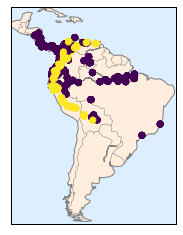

In [14]:
m = Basemap(projection='cyl', resolution='c',
            llcrnrlat=ygrid.min(), urcrnrlat=ygrid.max(),
            llcrnrlon=xgrid.min(), urcrnrlon=xgrid.max())

m.fillcontinents(color='#FFEEDD')
m.drawcoastlines(color='gray', zorder=2)
m.drawcountries(color='gray', zorder=2)
m.drawmapboundary(fill_color='#DDEEFF')


m.scatter(latlong[:, 1], latlong[:, 0], zorder=2, c=species, latlon=True)

Dalje, hoćemo da na osnovu informacija o tome gde se nalaze vrste koje posmatramo i u kom broju izmodelujemo njihovu sfernu gustinu raspodele. Biblioteka `scikit-learn` stavlja na rasolaganje metodu `KernelDensity` koja ovo računa. Za računanje rastojanja između tačaka na sferi, koristićemo [Heversine rastojanje](https://en.wikipedia.org/wiki/Haversine_formula) koja predstavlja dužinu velikog luka koji spaja dve tačke određene svojim geografskim dužinama i širinama.  

<img src='assets/harversine_distance.png'>

In [15]:
# sfericni ocenjivac gustine za Bradypus Variegatus tj. lenjivca
kde_bradypus_variegatus = neighbors.KernelDensity(kernel='gaussian', bandwidth=0.03, metric='haversine')
kde_bradypus_variegatus.fit(np.radians(latlong[species == 0]))

KernelDensity(algorithm='auto', atol=0, bandwidth=0.03, breadth_first=True,
              kernel='gaussian', leaf_size=40, metric='haversine',
              metric_params=None, rtol=0)

In [16]:
# sfericni ocenjivac gustine za Microryzomys Minutus tj. sumskog misa
kde_microryzomys_minutus = neighbors.KernelDensity(kernel='gaussian', bandwidth=0.03, metric='haversine')
kde_microryzomys_minutus.fit(np.radians(latlong[species == 1]))

KernelDensity(algorithm='auto', atol=0, bandwidth=0.03, breadth_first=True,
              kernel='gaussian', leaf_size=40, metric='haversine',
              metric_params=None, rtol=0)

In [17]:
kdes = [kde_bradypus_variegatus, kde_microryzomys_minutus]

Dalje, želimo da na mapi prikažemo gustinu raspodele verovatnoća.

In [19]:
# zbog vizuelizacije proredicemo sa faktorom 5 koriscene podele
X, Y = np.meshgrid(xgrid[::5], ygrid[::5][::-1])

# informaciju o brojnosti vrste nalaze se u nizu data.coverages na poziciji 6 
land_reference = data.coverages[6][::5, ::5]

# vrednosti koje nedostaju su obelezene sa -9999 i odnose se na vodene povrsine 
# sve druge vrednosti vece od ove predstavljaju regularne vrednosti
# zato ce se ova maska iskoristiti za filtriranje vrednosti
land_mask = (land_reference > -9999).ravel()

xy = np.vstack([Y.ravel(), X.ravel()]).T
xy = np.radians(xy[land_mask])

Slike sa gustinama raspodele prikazaćemo na dva susedna grafika. 

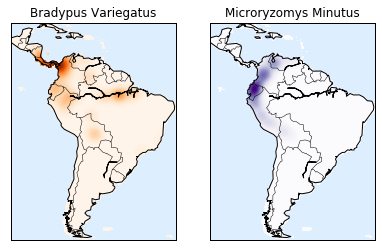

In [21]:
fig, ax = plt.subplots(1, 2)
fig.subplots_adjust(left=0.05, right=0.95, wspace=0.05)

species_names = ['Bradypus Variegatus', 'Microryzomys Minutus']
cmaps = ['Oranges', 'Purples']

# za svaku vrstu pojedinacno
for i, axi in enumerate(ax):
    
    # postavljamo naslov grafika sa imenom vrste
    axi.set_title(species_names[i])
    
    # iscrtavamo mapu, postupno, na isti nacin kao i u prethodnom primeru
    m = Basemap(projection='cyl', llcrnrlat=Y.min(),
                urcrnrlat=Y.max(), llcrnrlon=X.min(),
                urcrnrlon=X.max(), resolution='c', ax=axi)
    
    m.drawmapboundary(fill_color='#DDEEFF')
    m.drawcoastlines()
    m.drawcountries()
    
    # ocitavamo estimator prostorne gustine raspodele za tekucu vrstu
    kde = kdes[i]

    # i izracunavamo ocene koje estimator daje za tekucu x, y koordinatu 
    Z = np.full(land_mask.shape[0], -9999.0)
    Z[land_mask] = np.exp(kde.score_samples(xy))
    Z = Z.reshape(X.shape)

    # funkcija contourf iscrtava i boji konture zadatim bojama u nijansama koje su izracunate estimatorom
    levels = np.linspace(0, Z.max())
    axi.contourf(X, Y, Z, levels=levels, cmap=cmaps[i])

Primer je pozajmljen iz knjige [Python Data Science Handbook](https://jakevdp.github.io/PythonDataScienceHandbook/05.13-kernel-density-estimation.html) koju toplo preporučujemo za prelistavanje.